# 1. Read Data and Assign Labels

In [1]:
INPUT_1 = "/content/drive/MyDrive/dataset/inscribe_data/companies.txt"
INPUT_2 = "/content/drive/MyDrive/dataset/inscribe_data/individuals.txt"

with open(INPUT_1, "r") as in_1:
  data1 = in_1.read().split("\n")

with open(INPUT_2, "r") as in_2:
  data2 = in_2.read().split("\n")

d1 = {'input_text': data1, 'label': [0 for ele in data1]}
d2 = {'input_text': data2, 'label': [1 for ele in data2]}

Checking Companies with label 0

In [2]:
import pandas as pd

df1 = pd.DataFrame.from_dict(d1)
df1.head(3)

,input_text,label
0,Albuquerque Dsm Club,0
1,Teriyaki Hawaii,0
2,Allure Electrolysis Waxing,0


## 1.1 Data Cleaning

Dropping duplicates

In [3]:
print(len(df1))
df1 = df1.drop_duplicates()
len(df1)

161056


161056

Checking Individuals with label 1

In [4]:
df2 = pd.DataFrame.from_dict(d2)
df2.head(3)

,input_text,label
0,David Kagan,1
1,Angel Donchev,1
2,Erika Parisi,1


Dropping duplicates

In [5]:
print(len(df2))
df2 = df2.drop_duplicates()
len(df2)

94247


90883

Concatenating two dataframes and dropping duplicates

In [6]:
df = pd.concat([df1,df2])

print(len(df))
df = df.drop_duplicates(subset="input_text",
                     keep=False)
len(df)

251939


251665

In [7]:
print(df.head(3))
print("-"*15)
print(df.tail(3))

                   input_text  label
0        Albuquerque Dsm Club      0
1             Teriyaki Hawaii      0
2  Allure Electrolysis Waxing      0
---------------
            input_text  label
94243       Mark Dudas      1
94244      Parag Dixit      1
94245  Andrew Battista      1


Checking NaN values in the DataFrame

In [8]:
df.isna().sum().sum()

0

Checking Empty Strings - These might create noises since they are None and may lead to performance decrease


In [9]:
def check_empty_strings(s) -> bool:
  return len(s.replace(" ", "")) > 0

df["string_content"] = df.apply(lambda row: check_empty_strings(row["input_text"]), axis=1)
df[df.string_content == False]

,input_text,label,string_content


In [10]:
df = df.drop(df[df.string_content == False].index)

df.head(-10)

,input_text,label,string_content
0,Albuquerque Dsm Club,0,True
1,Teriyaki Hawaii,0,True
2,Allure Electrolysis Waxing,0,True
3,Los Primos Auto Sales,0,True
4,John Wesselius,0,True
...,...,...,...
94229,Paul Coulombe,1,True
94230,Vinod Chavan,1,True
94231,Nishank Chandawala,1,True
94232,Zachary Butler,1,True


Max length of a string in training data is 32. Therefore, there is no need to limit that.

In [68]:
int(df["input_text"].str.len().max())

32

Removing punctuations from input texts

In [11]:
df["input_text"] = df['input_text'].str.lower().replace('[^\w\s]','')
df = df.drop(columns=["string_content"])

df.head(-10)

,input_text,label
0,albuquerque dsm club,0
1,teriyaki hawaii,0
2,allure electrolysis waxing,0
3,los primos auto sales,0
4,john wesselius,0
...,...,...
94229,paul coulombe,1
94230,vinod chavan,1
94231,nishank chandawala,1
94232,zachary butler,1


# 2. Modelling

We are going to need numerical values instead of texts. Thus, assigning numerical values using **CountVectorizer** . More info: https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html

In [12]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer()
X = vectorizer.fit_transform(df["input_text"])
y = df["label"]

Splitting train and test data

In [13]:
import numpy as np
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=48)

## 2.1.1 LogisticRegression

For binary classification (such as this task), starting with logistic regression is a good choice since it might give us a baseline. 

In [14]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

logreg = LogisticRegression(random_state=16)

logreg.fit(X_train, y_train)

y_pred = logreg.predict(X_test)

cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
cnf_matrix

/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


array([[27698,  4489],
       [ 2085, 16061]])

## 2.1.2 Visualizing the results

Text(0.5, 257.44, 'Predicted label')

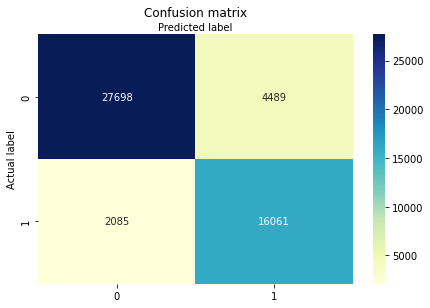

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

class_names=[0,1] # referring to COMPANY & CUSTOMER
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

The weighted-averaged F1 score is calculated by taking the mean of all per-class F1 scores while considering each class's support. Support refers to the number of actual occurrences of the class in the dataset.

Therefore, we will take into account the **weighted F1 score**.

In [16]:
from sklearn.metrics import f1_score

f1_score(y_test, y_pred, average='weighted')

0.8709135822543531

Hash map for labels and their names

In [17]:
res_dict = {0:"COMPANY", 1:"CUSTOMER"}

## 2.1.3 Printing wrong results

In [18]:
count = 0
for input, prediction, label in zip(X_test, y_pred, y_test):
  if count == 5: break
  elif prediction != label:
    count += 1
    print(vectorizer.inverse_transform(input), 'has been classified as ', res_dict[prediction], 'and should be ', res_dict[label])

[array(['leonard', 'cassert'], dtype='<U31')] has been classified as  COMPANY and should be  CUSTOMER
[array(['shelby', 'byler'], dtype='<U31')] has been classified as  CUSTOMER and should be  COMPANY
[array(['brien', 'keane'], dtype='<U31')] has been classified as  CUSTOMER and should be  COMPANY
[array(['melinda', 'sacks'], dtype='<U31')] has been classified as  COMPANY and should be  CUSTOMER
[array(['lance', 'leland', 'provencher'], dtype='<U31')] has been classified as  CUSTOMER and should be  COMPANY


Getting output feature names for transformation

In [19]:
vectorizer.get_feature_names_out()

array(['00', '000', '00142', ..., 'zywicki', 'zywien', 'zzzs'],
      dtype=object)

## 2.1.4 Inference on User Inputs

Inputs need to be normalized in the way we normalized our train and test data.
- Removing punctuations
- Lowering text

In [20]:
import string

string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

Following code is preprocessing the custom inputs coming from users.
It:
- removes punctuations (above)
- lowers the text
- Raise error if length is longer than 32 chars.

In [21]:
def preprocess_input(List) -> list:

  List = [s.lower() for s in List]
  List = [s.translate(str.maketrans('', '', string.punctuation)) for s in List]
  for s in List:
    if len(s) > 32:
      raise Exception("One or more strings are longer than 32 chars")
  return List

def predictor(name_l) -> None:
  name_l = preprocess_input(name_l)

  tmp = vectorizer.transform(name_l)
  preds = logreg.predict(tmp)
  
  res = [res_dict[ele] for ele in preds]
  for item in zip(name_l, res):
    print("Input text:", item[0], "\n", "Prediction", item[1])
    print("-"*10)

s1 = "inscribeAI ~"
s2 = "string that"
s3 = "Erdal Genc"
s4 = "Oisín Moran"
s5 = "jp morgan"
s6 = "paramount S&P"

predictor([s1, s2, s3, s4, s5, s6])

Input text: inscribeai  
 Prediction COMPANY
----------
Input text: string that 
 Prediction COMPANY
----------
Input text: erdal genc 
 Prediction CUSTOMER
----------
Input text: oisín moran 
 Prediction CUSTOMER
----------
Input text: jp morgan 
 Prediction COMPANY
----------
Input text: paramount sp 
 Prediction COMPANY
----------


## 2.2.1 Random Forest

This is a tree based algorithm which may result better predictions (from my experience, tree based models are quite effective on tabular data). Therefore, second approach will be Random Forest. For more:
https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

In [22]:
from sklearn.ensemble import RandomForestClassifier

# Setting random_state so that we can get same results (consistency in terms of producing same results)
RFCclf = RandomForestClassifier(n_estimators=50, bootstrap=False, random_state=48)

RFCclf.fit(X_train, y_train)

y_pred = RFCclf.predict(X_test)

cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
cnf_matrix

array([[28011,  4176],
       [ 4262, 13884]])

Text(0.5, 257.44, 'Predicted label')

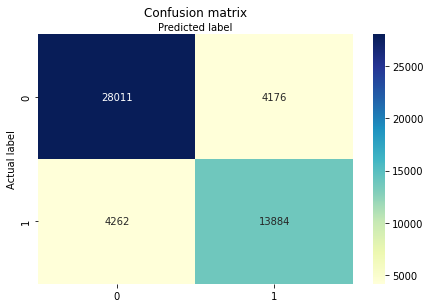

In [23]:
class_names=[0,1] # referring to COMPANY & CUSTOMER
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [24]:
f1_score(y_test, y_pred, average='weighted')

0.83226923581755

In [25]:
count = 0
for input, prediction, label in zip(X_test, y_pred, y_test):
  if count == 5: break
  elif prediction != label:
    count += 1
    print(vectorizer.inverse_transform(input), 'has been classified as ', res_dict[prediction], 'and should be ', res_dict[label])

[array(['cassert', 'leonard'], dtype='<U31')] has been classified as  COMPANY and should be  CUSTOMER
[array(['byler', 'shelby'], dtype='<U31')] has been classified as  CUSTOMER and should be  COMPANY
[array(['hall', 'joy'], dtype='<U31')] has been classified as  COMPANY and should be  CUSTOMER
[array(['gunter', 'unruh'], dtype='<U31')] has been classified as  CUSTOMER and should be  COMPANY
[array(['brien', 'keane'], dtype='<U31')] has been classified as  CUSTOMER and should be  COMPANY


## 2.3.1 SBert

SentenceTransformers is a Python framework for state-of-the-art sentence, text embeddings. 

In [28]:
!pip install torch transformers evaluate memory_profiler datasets -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.4/81.4 KB 3.0 MB/s eta 0:00:00


In [51]:
X = df["input_text"]
y = df["label"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=48)

## 2.3.2 Preparing Dataset for HuggingFace Dataset Class for Compatibility

In [57]:
import datasets
import pandas as pd


train_df = pd.DataFrame({
     "text" : X_train,
     "label" : y_train
})

test_df = pd.DataFrame({
     "text" : X_test,
     "label" : y_test
})

train_dataset = Dataset.from_dict(train_df)
test_dataset = Dataset.from_dict(test_df)
my_dataset_dict = datasets.DatasetDict({"train":train_dataset,"test":test_dataset})

In [58]:
my_dataset_dict

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 201332
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 50333
    })
})

## 2.3.3 Using Sentence Embeddings

Dataset consists of multiple tokens, therefore using sentence embeddings instead of token count is better approach. Also, BERT (transformers) keep location information of the tokens.
Source: https://towardsdatascience.com/sentence-embedding-3053db22ea77

In [59]:
import torch
import random
from transformers.file_utils import is_tf_available, is_torch_available, is_torch_tpu_available
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from datasets import load_metric
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
%load_ext memory_profiler

# Call the Tokenizer
tokenizer = AutoTokenizer.from_pretrained('sentence-transformers/bert-base-nli-mean-tokens', do_lower_case=True)

def preprocess_function(examples):
    return tokenizer(examples["text"], truncation=True)

tokenized_dataset = my_dataset_dict.map(preprocess_function, batched=True)

The memory_profiler extension is already loaded. To reload it, use:
  %reload_ext memory_profiler


  0%|          | 0/202 [00:00<?, ?ba/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


  0%|          | 0/51 [00:00<?, ?ba/s]

In [60]:
from transformers import DataCollatorWithPadding

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

## Using F1 score

In [62]:
import evaluate

f1_metric = evaluate.load("f1")

## 2.3.4 Pytorch as Backend

We are returing tensors with pytorch since it is slightly easier to read. HuggingFace also supports tensorflow for returning tensors.

In [63]:
import numpy as np
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy.compute(predictions=predictions, references=labels)

id2label = {0: "COMPANY", 1: "CUSTOMER"}
label2id = {"COMPANY": 0, "CUSTOMER": 1}

model = AutoModelForSequenceClassification.from_pretrained(
    "distilbert-base-uncased", num_labels=2, id2label=id2label, label2id=label2id
)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_transform.bias', 'vocab_projector.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'classifier.bias', 'classifier

## Let's train it!

In [66]:
training_args = TrainingArguments(
    output_dir="inScribe_model",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=2,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["test"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

trainer.train()

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
The following columns in the training set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: token_type_ids, text. If token_type_ids, text are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 201332
  Num Epochs = 2
  Instantaneous batch size

Epoch,Training Loss,Validation Loss


Epoch,Training Loss,Validation Loss


KeyboardInterrupt: ignored

# 3. Future Steps & Considerations


1.   Logistic Regression performs quite good for a start. We can definitely improve its performance by cleaning the outliers. To find outliers, we need to consider that:
  *   It can be a wrong data entry (Eg. human typing error)
  *   It can be a data that has values that are not relevant (Eg. an entry of total which is calculated as the sum of the above columns. This data can be misleading at times so it should be removed)
  *   It can be a data entry that is all or most fields blank (Eg. a row in the data where all fields are blank. This row maybe not contributing anything to the analysis)
  *   It may be extreme values which fall way out of the range of the other data (Eg. length is too long to be a company or customer name)

2.   Random Forest is both slower and performing slightly worse. To be sure, we might need to test it again after removing the outliers.

3.  Even though model training is not completed yet, I do believe its performance will be better. It is because it is based on BERT and its performance might be considered as SoTA. However, it is a heavy model and not cheap-to-deploy, we might just pick Logistic Regression for the speed.

4.  Employing LightGBM and XGBoost might also be effective since they are boosting algorithms and might increase performance. 

5.  If there was time I would also try TF-IDF. Because, **CountVectorizer** simply counts the number of times a word appears in a document (using a bag-of-words approach), while **TF-IDF** Vectorizer takes into account not only how many times a word appears in a document but also how important that word is to the whole corpus.

6. After trying Logistic Regression, Random Forest, LightGBM, we can convert results to an ensemble model. To be specific, following this tutorial: https://www.geeksforgeeks.org/ensemble-methods-in-python/

7. To deploy these models, I would follow these steps using **FastAPI** For Logistic Regression and Random Forest: https://towardsdatascience.com/colabcode-deploying-machine-learning-models-from-google-colab-54e0d37a7b09
For HuggingFace Models: 
https://colab.research.google.com/drive/1jrKblK4iISeilrCasc02G8JAd8Z3G45h?usp=sharing

8. I tried not to exceed 4 hours. Training a transformer taking a lot of time. Therefore, I am submitting this task without completing that. 


